In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960

#This link has expired time. So you must go to https://www.kaggle.com/code/allunia/breast-cancer, click on three dots on the right and
#click on "open in colab" option. Then replace this link and run. We don't find other way to download IDC dataset
DATA_SOURCE_MAPPING = 'pretrained-pytorch-models:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2847%2F4958%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240801%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240801T222006Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da94b90f1d68fad876736e14b5c6538ebea871087f974a137c66773c87e47f2f7a3b73a384fe33d05a269f67bbfd725622e00167ab20dd3e3b769aa353d482c1505cf7ff721f640fe789a8c1a6f881ed3618387478d9928d204467b8bd847a0bb849699a6808347d9642770378c4ba272aecb9a363f015ce6e295e118e9dcd0c6d0ab6f306e0fedf1388e8eaa2f998f44ff6ef5832344abe083f684fc15de97f9239fcf3d8a6ba4bac35327342d6ef9ec0e77ed1516ffc6f67112eb8d54c6386a2bcfab3486d2dd8e3a2d4ec6b84dabf95e240f85b6b64ec9c8029e00b8259a3e1d5e5671a4f5ba9dd7cd21cc16ce576d020d785e8a0e82d96dd9a889ccf17bac,breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240801%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240801T222006Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D71f3e983bca3d67ebb9b12e0b390a1c9cab43514bafba94326e7b9ce5a4c22b3006b265956473ab538b5409ae76593b501ca42620861e2fdadc11908ffa7031a8885243ff960628a2e62b8a44a975f5cfba391a65ddba2ff3da790607d79d7eef629d222c1d3dd3efbb4449bbffeae778772b9f979e1995f10374fc771ef0561930df72f8427ce8ea948d3715f0e19f319deec565213e12b7f251c9b4b03385a5b6a16f3d65a7bf0d62d5db1b75fc5a63b70cea014b8bf73340ecad60b6fb081da51f041921d0159ad8a6507fde93197b08754386e033f31b3d6b8695ba35534de1dba156d5f9c5275e18f11da5110d87d267e0ea878dfb4acb76574e3c68bf8,breastcancermodel:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F448448%2F1362309%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240801%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240801T222006Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fb8854d9b2abb528fae713e7c32768c7d4f44a3eed414762e9a8ecac1cba5bf35b36b29df4bc29358c635d7c75f69e63842cdfa40a300b22574d8220536d31e2c10996da49d6ca85d030ed5bc91e502c4eb39445857a51c7722683bf0f2bbb7114f92ed18cc85be0e17c61fa490f942cc62194d4ab4a0619b123b4d6f80f84fd7090bef6961e56044af10bb79172180a8da2a5fee716e9d24ad534ad3eccff31e80a58a38edd1ac850e8ed4f85e2b52dd3a5d82f5d5410adb8a4a6eef8c0b52842c31bc7e5403c58c336019edbf042265c51fdaa5dff8af168198037532bc12f88bd6ab65737510d5cd8fdb4834f08b80a929a680944fcb00b91f951fdbe071'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 359530952 bytes downloaded
Downloaded and uncompressed: pretrained-pytorch-models
[==================================================] 3326820824 bytes downloaded
Downloaded and uncompressed: breast-histopathology-images
[==================================================] 46276192 bytes downloaded
Downloaded and uncompressed: breastcancermodel
Data source import complete.


# Preparation & peek at the data structure <a class="anchor" id="prep"></a>

## Loading packages and setting <a class="anchor" id="setup"></a>

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

### Settings

In [ ]:
run_training = True
retrain = False
find_learning_rate = False

## Exploring the data structure <a class="anchor" id="explorestructure"></a>

In [6]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

### How many patches do we have in total?

In [7]:
total_images = 0
for n in range(len(folder)):
# for n in range(10):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [8]:
total_images

277524

### Storing the image_path, patient_id and the target

In [9]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

data.head()

patient_id                                               path target
0      12930  ../input/breast-histopathology-images/IDC_regu...      0
1      12930  ../input/breast-histopathology-images/IDC_regu...      0
2      12930  ../input/breast-histopathology-images/IDC_regu...      0
3      12930  ../input/breast-histopathology-images/IDC_regu...      0
4      12930  ../input/breast-histopathology-images/IDC_regu...      0

Ok, now for each patient we know the path for each patch as well as if it contains IDC or not (the target).

In [10]:
data.shape

(277524, 3)

No surprise. This matches the total number of patches.

# Exploratory analysis <a class="anchor" id="eda"></a>

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [11]:
data.target = data.target.astype(np.int64)

In [12]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

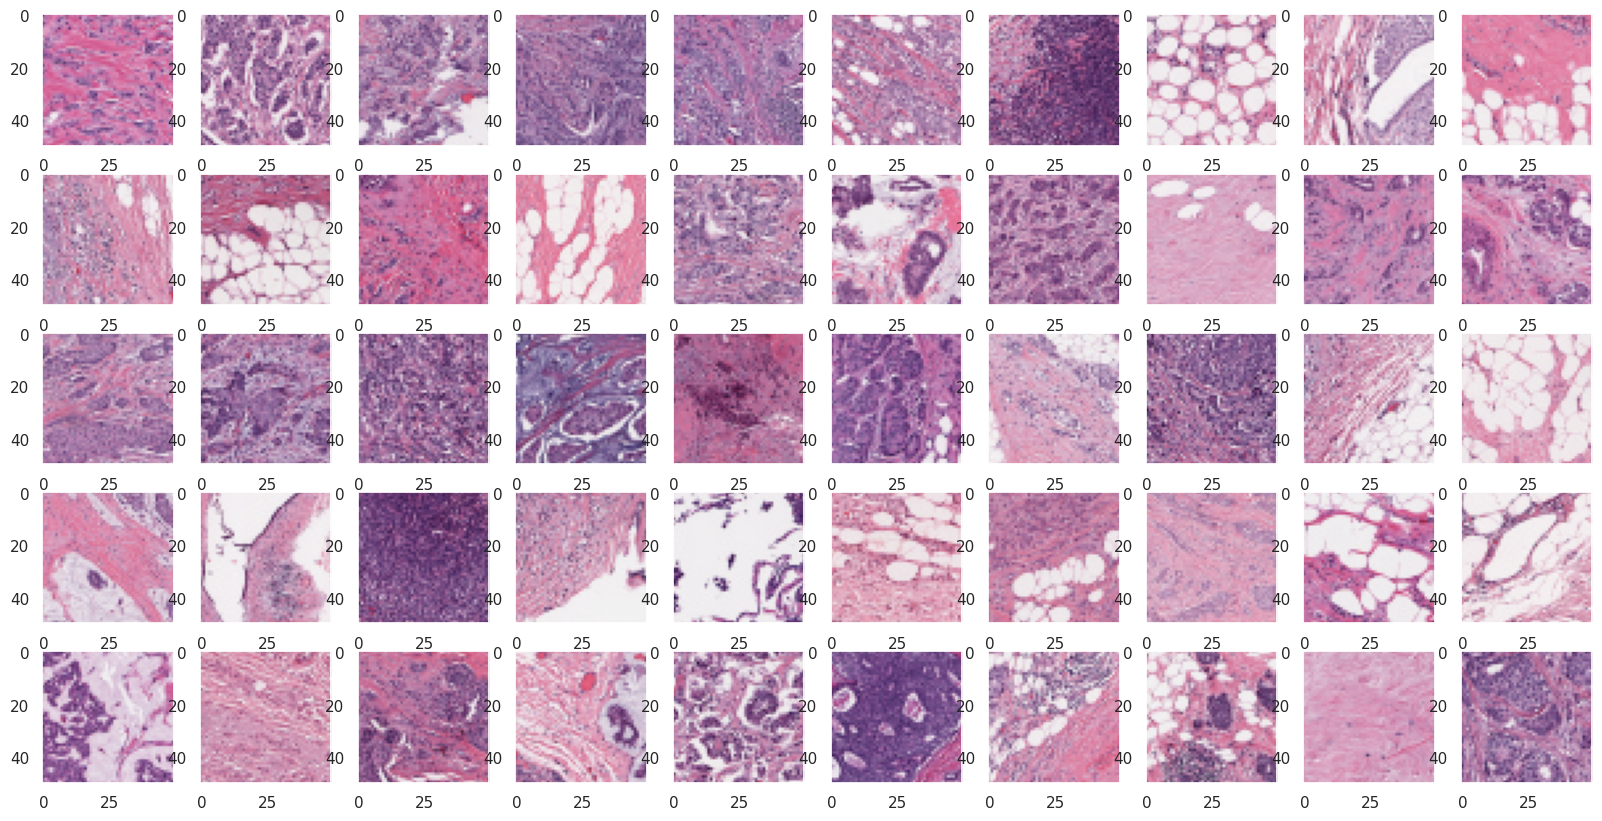

In [13]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

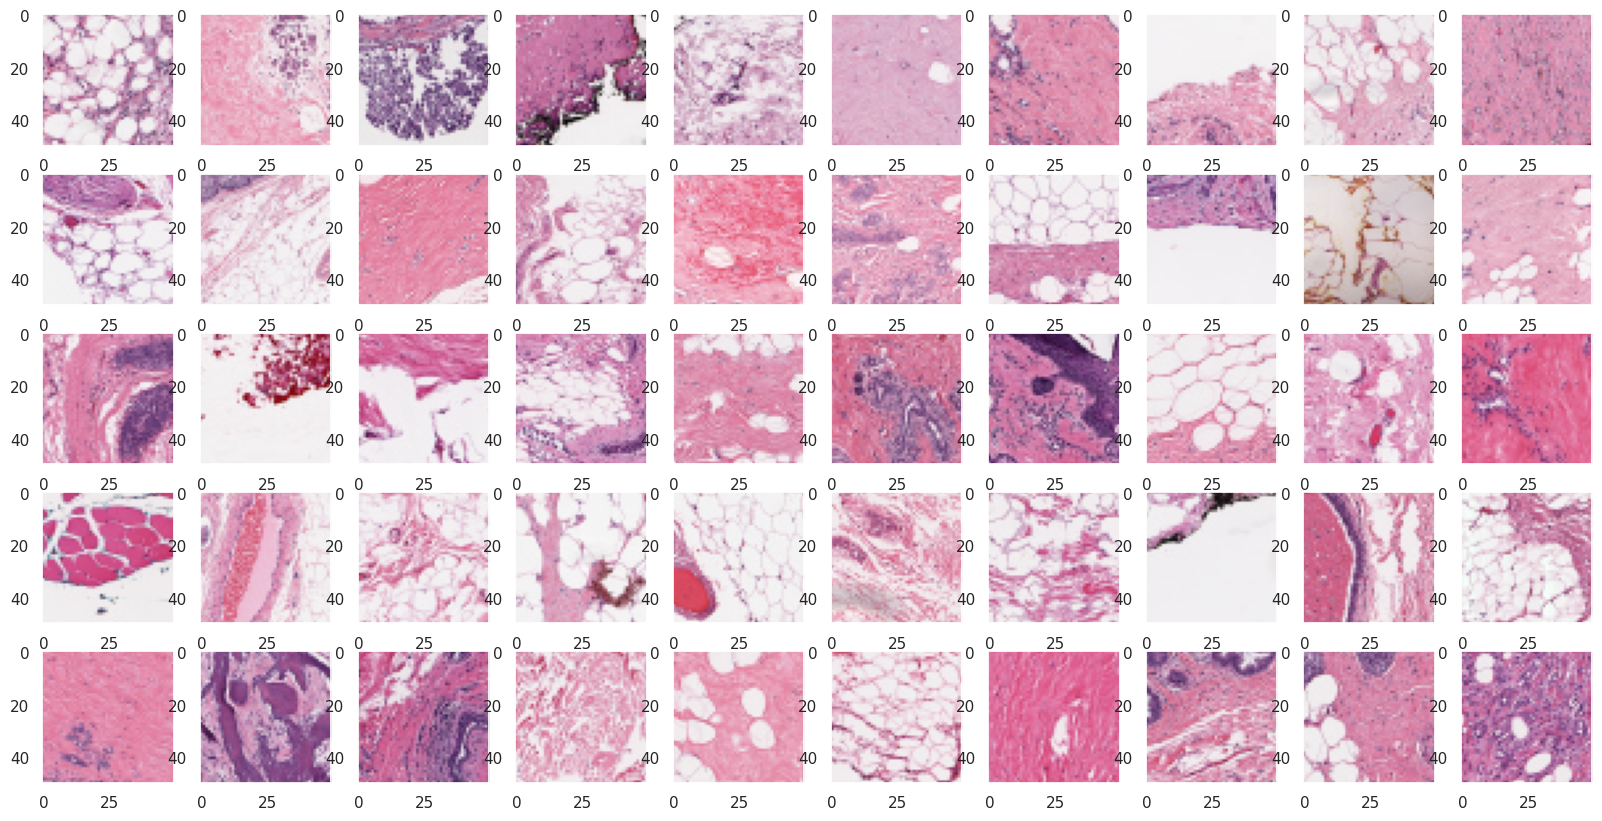

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [15]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int64)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int64)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

# Setting up the machine learning workflow <a class="anchor" id="workflow"></a>

## Settings <a class="anchor" id="ml_settings"></a>

In [17]:
BATCH_SIZE = 32
NUM_CLASSES = 2

OUTPUT_PATH = "/content/drive/MyDrive/Dataset kaggle/Pruebas para submit/"
MODEL_PATH = "/content/drive/MyDrive/Dataset kaggle/Pruebas para submit/"
LOSSES_PATH = "/content/drive/MyDrive/Dataset kaggle/Pruebas para submit/"

In [18]:
torch.manual_seed(0)
np.random.seed(0)

## Load stylegan2 ada generator

In [19]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.16 MiB | 28.05 MiB/s, done.
Resolving deltas: 100% (101/101), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.9 MB/s eta 0:00:00


In [20]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class'\
                   'when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running '\
            'on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0,
                   noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi,
          noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128)\
    .clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [21]:
URL = "/content/drive/MyDrive/Dataset kaggle/models/network-snapshot-012480-IDC-20p"

print('Loading networks from "%s"...' % URL)
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema']\
      .requires_grad_(False).to(device)

Loading networks from "/content/drive/MyDrive/Dataset kaggle/models/network-snapshot-012480-IDC-20p"...


Seed 4020


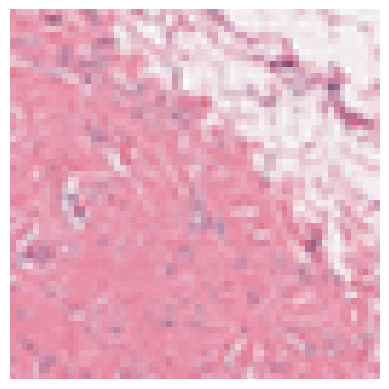

Seed 4021


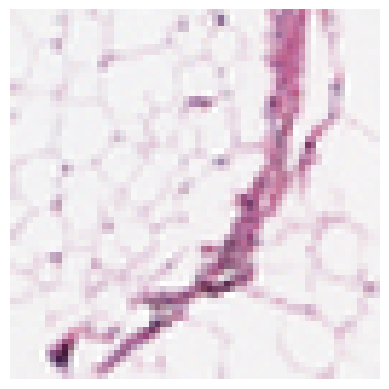

Seed 4022


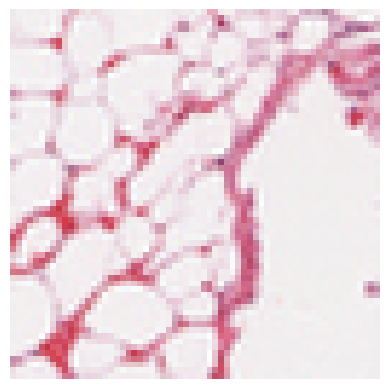

In [25]:
# Choose your own starting and ending seed.
SEED_FROM = 4020
SEED_TO = 4023

# Generate fake images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  # class_idx=1 or 0
  img = generate_image(device, G, z, class_idx=0)
  display_image(img)

## Validation strategy <a class="anchor" id="validation"></a>

In [153]:
data.head()
data.loc[:, "target"] = data.target.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [154]:
patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.3, random_state=0)

In [155]:
print(len(train_ids)/patients.shape[0]*100, len(dev_ids)/patients.shape[0]*100, len(test_ids)/patients.shape[0]*100)

69.89247311827957 9.31899641577061 20.78853046594982


Now it's 70 % train and 10 % for dev and 20% test.

In [156]:
print(len(train_ids), len(dev_ids), len(test_ids))

195 26 58


In [157]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [158]:
# Generate a subsample of x% training data
train_df_sample_3_percent = train_df.sample(frac=0.03, random_state=42)  # Use 42 for random state for better reproducibility
train_df_sample_5_percent = train_df.sample(frac=0.05, random_state=42)  # Use 42 for random state for better reproducibility
train_df_sample_10_percent = train_df.sample(frac=0.1, random_state=42)  # Use 42 for random state for better reproducibility
train_df_sample_20_percent = train_df.sample(frac=0.20, random_state=42)  # Use 42 for random state for better reproducibility

# Take a look
print(f"Tamaño original del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del subconjunto de entrenamiento (3%): {len(train_df_sample_3_percent)}")
print(f"Tamaño del subconjunto de entrenamiento (5%): {len(train_df_sample_5_percent)}")
print(f"Tamaño del subconjunto de entrenamiento (10%): {len(train_df_sample_10_percent)}")
print(f"Tamaño del subconjunto de entrenamiento (20%): {len(train_df_sample_20_percent)}")

Tamaño original del conjunto de entrenamiento: 194302
Tamaño del subconjunto de entrenamiento (3%): 5829
Tamaño del subconjunto de entrenamiento (5%): 9715
Tamaño del subconjunto de entrenamiento (10%): 19430
Tamaño del subconjunto de entrenamiento (20%): 38860


In [159]:
print(train_df_sample_3_percent.target.value_counts())
print(train_df_sample_5_percent.target.value_counts())
print(train_df_sample_10_percent.target.value_counts())
print(train_df_sample_20_percent.target.value_counts())

target
0    4202
1    1627
Name: count, dtype: int64
target
0    7013
1    2702
Name: count, dtype: int64
target
0    14035
1     5395
Name: count, dtype: int64
target
0    28112
1    10748
Name: count, dtype: int64


Text(0.5, 1.0, '20% Train data')

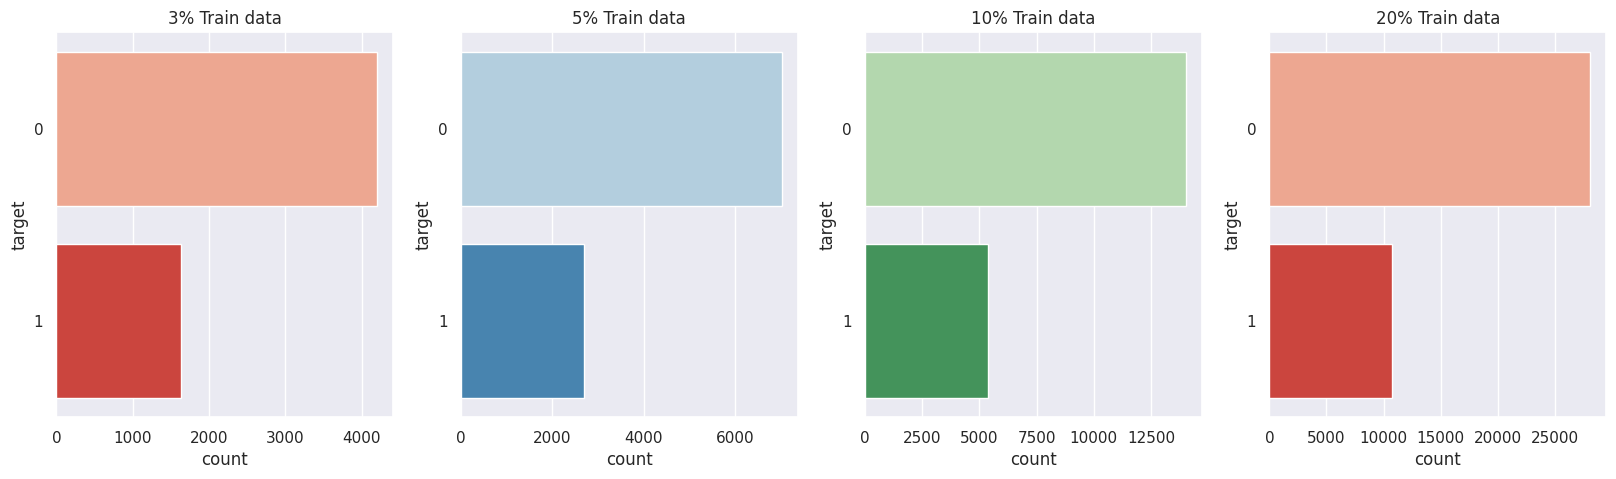

In [126]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.countplot(train_df_sample_3_percent.target, ax=ax[0], palette="Reds")
ax[0].set_title("3% Train data")
sns.countplot(train_df_sample_5_percent.target, ax=ax[1], palette="Blues")
ax[1].set_title("5% Train data")
sns.countplot(train_df_sample_10_percent.target, ax=ax[2], palette="Greens");
ax[2].set_title("10% Train data")
sns.countplot(train_df_sample_20_percent.target, ax=ax[3], palette="Reds");
ax[3].set_title("20% Train data")

Text(0.5, 1.0, 'Val data')

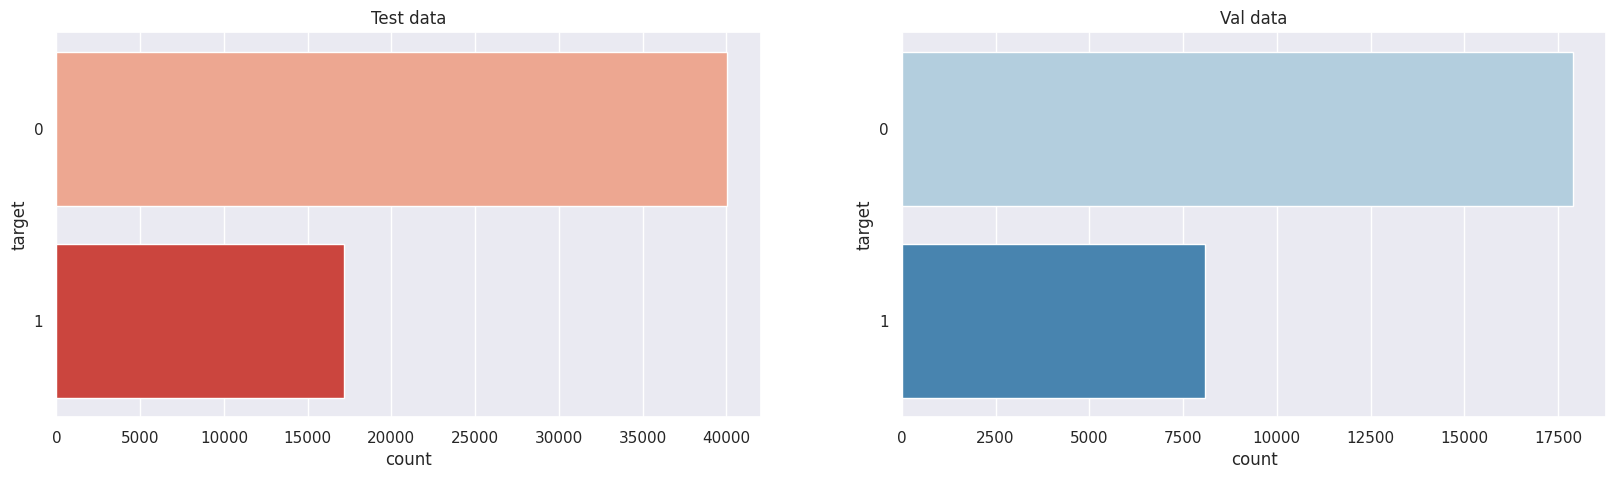

In [127]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(test_df.target, ax=ax[0], palette="Reds")
ax[0].set_title("Test data")
sns.countplot(dev_df.target, ax=ax[1], palette="Blues")
ax[1].set_title("Val data")

## Creating pytorch image datasets <a class="anchor" id="image_datasets"></a>

It's often a good idea to start as simple as possible and to grow more complex while iterating through the solution. This way we prevent to build up models that are likely overfitted to the available data and we can find out useful ideas in a strategic manner instead of trying out every idea at random.

The simplest transformations we can do for each image are:

* resizing the images to the desired input shape
* performing horizontal and vertical flips

In our case the patches are of shape 50x50x3 and we could set this as our input shape. As CNNs are translational but not rotational invariant, it's a good idea to add flips during training. This way we increase the variety of our data in a meaningful way as each patch could be rotated as well on the tissue slice. As we are not looking at the whole tissue we are not loosing spatial connections between patches and it's not important that some neighboring patches are rotated in different directions.

In [39]:
def my_transform(key="train", plot=False):
    train_sequence = [transforms.Resize((256,256)),
                      # transforms.RandomHorizontalFlip(),
                      # transforms.ColorJitter()
                      ]
    val_sequence = [transforms.Resize((256,256))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

In [152]:
class CombinedDataset(Dataset):
    def __init__(self, df, generator, device, augmentation_ratio, transform=None):
        self.df = df
        self.generator = generator
        self.device = device
        self.augmentation_ratio = augmentation_ratio
        self.transform = transform
        self.class_counts = df['target'].value_counts()
        self.synthetic_size_per_class = (self.class_counts * augmentation_ratio).astype(int)
        self.max_class_size = (self.class_counts + self.synthetic_size_per_class).max()
        self.synthetic_size_per_class = self.max_class_size - self.class_counts
        self.total_size = len(df) + self.synthetic_size_per_class.sum()

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        if idx < len(self.df):
            row = self.df.iloc[idx]
            image_path = row['path']
            label = row['target']
            image = Image.open(image_path).convert('RGB')
        else:
            synthetic_idx = idx - len(self.df)
            class_idx = 1 if synthetic_idx < self.synthetic_size_per_class[1] else 0
            seed = synthetic_idx % self.synthetic_size_per_class[class_idx]
            z = np.random.RandomState(seed).randn(1, self.generator.z_dim)
            z = torch.from_numpy(z).to(self.device)
            label_tensor = self.get_label(self.generator, self.device, class_idx)
            with torch.no_grad():
                img = self.generator(z, label_tensor, truncation_psi=1.0, noise_mode='const')
                img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
                image = Image.fromarray(img[0].cpu().numpy(), 'RGB')
            label = class_idx

        if self.transform:
            image = self.transform(image)
        label = int(label)
        return {'image': image, 'label': label}

    def get_label(self, G, device, class_idx):
        label = torch.zeros([1, G.c_dim], device=device)
        if G.c_dim != 0:
            label[:, class_idx] = 1
        return label

In [41]:
# Define the generator and device
device = torch.device('cuda')
URL = "/content/drive/MyDrive/Dataset kaggle/models/network-snapshot-012480-IDC-20p"
with dnnlib.util.open_url(URL) as fp:
    generator = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

augmentation_ratio = 0.3  # augmentation_ratio, for example, 0.3 for 30%

In [160]:
train_dataset_3_percent = CombinedDataset(train_df_sample_3_percent, generator, device, augmentation_ratio, transform=my_transform(key="train"))
train_dataset_5_percent = CombinedDataset(train_df_sample_5_percent, generator, device, augmentation_ratio, transform=my_transform(key="train"))
train_dataset_10_percent = CombinedDataset(train_df_sample_10_percent, generator, device, augmentation_ratio, transform=my_transform(key="train"))
train_dataset_20_percent = CombinedDataset(train_df_sample_20_percent, generator, device, augmentation_ratio, transform=my_transform(key="train"))

In [161]:
# only resize
dev_dataset = CombinedDataset(dev_df, generator, device, 0, transform=my_transform(key="val"))
test_dataset = CombinedDataset(test_df, generator, device, 0, transform=my_transform(key="val"))

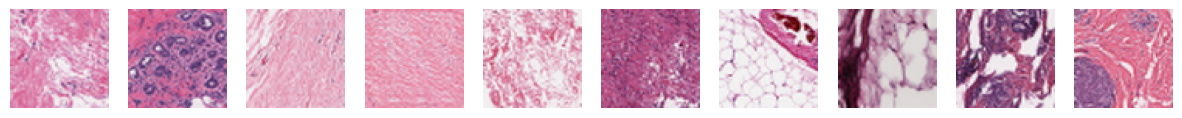

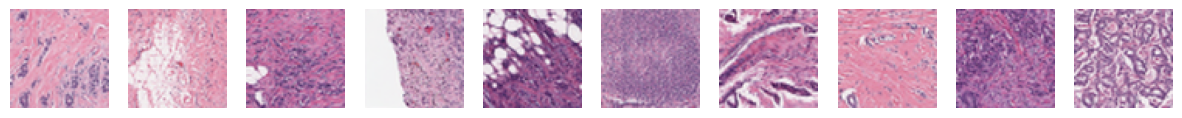

In [47]:
import matplotlib.pyplot as plt

# Visualize fake images
def visualize_synthetic_images(generator, device, class_idx,num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        z = np.random.randn(1, generator.z_dim)
        z = torch.from_numpy(z).to(device)
        label_tensor = torch.zeros([1, generator.c_dim], device=device)
        if generator.c_dim != 0:
            label_tensor[:, class_idx] = 1
        with torch.no_grad():
            img = generator(z, label_tensor, truncation_psi=1.0, noise_mode='const')
            img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
            image = img[0].cpu().numpy()
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Visualize 10 synthetic images
visualize_synthetic_images(generator, device, class_idx=0, num_images=10)
visualize_synthetic_images(generator, device, class_idx=1, num_images=10)

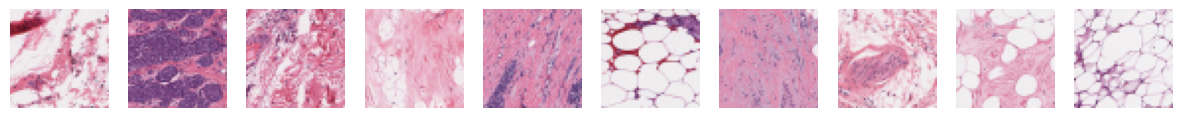

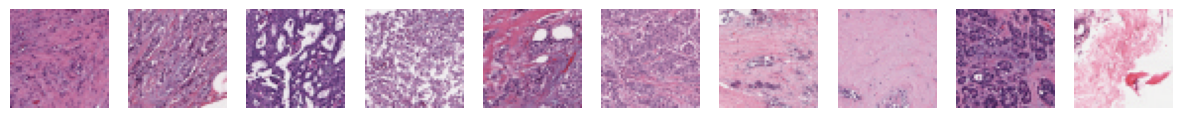

In [46]:
# Visualize real images
def visualize_real_images(df, class_idx, num_images=5):
    class_df = df[df['target'] == class_idx]
    fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
    for i, (index, row) in enumerate(class_df.sample(num_images).iterrows()):
        image_path = row['path']
        image = PIL.Image.open(image_path).convert('RGB')
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Visualize 10 real images from train data
visualize_real_images(train_df_sample_20_percent, class_idx='0', num_images=10)
visualize_real_images(train_df_sample_20_percent, class_idx='1', num_images=10)

In [162]:
image_datasets = {"train": train_dataset_20_percent, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

## Creating pytorch dataloaders <a class="anchor" id="dataloaders"></a>


In [163]:
train_dataloader_3_percent = DataLoader(train_dataset_3_percent, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_dataloader_5_percent = DataLoader(train_dataset_5_percent, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_dataloader_10_percent = DataLoader(train_dataset_10_percent, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_dataloader_20_percent = DataLoader(train_dataset_20_percent, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [164]:
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [165]:
dataloaders = {"train": train_dataloader_20_percent, "dev": dev_dataloader, "test": test_dataloader}

## Defining the model structure <a class="anchor" id="model_structure"></a>

In [145]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [146]:
model = torchvision.models.resnet34(pretrained=True)
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
model = model.to(device)

512


In [168]:
criterion = nn.CrossEntropyLoss()

In [169]:
def f1_score(preds, targets):

    tp = (preds*targets).sum().to(torch.float32)
    fp = ((1-targets)*preds).sum().to(torch.float32)
    fn = (targets*(1-preds)).sum().to(torch.float32)

    epsilon = 1e-7
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    f1_score = 2 * precision * recall/(precision + recall + epsilon)
    return f1_score

## Building the training loop <a class="anchor" id="train_loop"></a>

In [170]:
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)

    running_loss_dict = {"train": [], "dev": [], "test": []}

    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)

                        #loss += l2_reg

                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step()
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1


                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders[phase].batch_size))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [226]:
def get_lr_search_scheduler(optimizer, min_lr, max_lr, max_iterations):
    # max_iterations should be the number of steps within num_epochs_*epoch_iterations
    # this way the learning rate increases linearily within the period num_epochs*epoch_iterations
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=max_iterations,
                                               step_size_down=max_iterations,
                                               mode="triangular")

    return scheduler

def get_scheduler(optimiser, min_lr, max_lr, stepsize):
    # suggested_stepsize = 2*num_iterations_within_epoch
    stepsize_up = np.int64(stepsize/2)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimiser,
                                               base_lr=min_lr,
                                               max_lr=max_lr,
                                               step_size_up=stepsize_up,
                                               step_size_down=stepsize_up,
                                               mode="triangular")
    return scheduler

In [171]:
start_lr = 1e-6
end_lr = 0.008

## Performing our trining config <a class="anchor" id="run"></a>

In CombinedDataset class, we define how we perform data augmentation. For this dataset, since the classes are highly imbalanced, we generate as much data for the minority class as needed to match the majority class and then apply another data augmentation with an augment ratio = 0.3. We do not use class weights, color jitter, or random horizontal flip in the transform.

In [175]:
# here you can modify the number of epochs
NUM_EPOCHS = 30
optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
results = train_loop(model, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
model, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]

if device == "cpu":
    OUTPUT_PATH += "prueba.pth"

torch.save(model.state_dict(), OUTPUT_PATH)

losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
losses_df.loc[:, "dev"] = loss_dict["dev"]
losses_df.loc[:, "test"] = loss_dict["test"]

Epoch 0/0
----------


  0%|          | 0/2284 [00:00<?, ?it/s]

train Loss: 0.3778 Acc: 0.8380


  0%|          | 0/1118 [00:00<?, ?it/s]

dev Loss: 0.3118 Acc: 0.8645


  0%|          | 0/2504 [00:00<?, ?it/s]

test Loss: 0.2910 Acc: 0.8811

Training complete in 34m 47s
Best val Acc: 0.864515


# Exploring results <a class="anchor" id="error_analysis"></a>

In [229]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            proba = outputs.cpu().numpy().astype(np.float64)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int64)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int64)

    predictions_df = predictions_df.dropna()
    return predictions_df

In [177]:
dev_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
test_predictions = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

dev_predictions = evaluate_model(model, dev_predictions, "dev")
test_predictions = evaluate_model(model, test_predictions, "test")

In [178]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

def print_classification_report(predictions_df):
    y_true = predictions_df["true"].astype(int)
    y_pred = predictions_df["predicted"].astype(int)
    y_proba = predictions_df["proba"].astype(float)

    auc_roc = roc_auc_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)


    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["no cancer", "cancer"]))
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

print("Test Set Metrics:")
print_classification_report(test_predictions)

Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

   no cancer       0.88      0.88      0.88     40054
      cancer       0.88      0.88      0.88     40054

    accuracy                           0.88     80108
   macro avg       0.88      0.88      0.88     80108
weighted avg       0.88      0.88      0.88     80108

AUC-ROC: 0.8573
Accuracy: 0.8811


# Training baseline model <a class="anchor" id="error_analysis"></a>

In [179]:
class BreastCancerDataset(Dataset):

    def __init__(self, df, transform=None):
        self.states = df
        self.transform=transform

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        image_path = self.states.path.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        if "target" in self.states.columns.values:
            target = int(self.states.target.values[idx])
        else:
            target = None

        return {"image": image,
                "label": target}

In [180]:
def my_transform_baseline(key="train", plot=False):
    train_sequence = [transforms.Resize((256,256)),
                      transforms.RandomHorizontalFlip(),
                      transforms.ColorJitter()
                      ]
    val_sequence = [transforms.Resize((256,256))]
    if plot==False:
        train_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        val_sequence.extend([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    data_transforms = {'train': transforms.Compose(train_sequence),'val': transforms.Compose(val_sequence)}
    return data_transforms[key]

In [181]:
train_df_sample_20_percent.head()

patient_id                                               path target  \
92408       10268  ../input/breast-histopathology-images/IDC_regu...      0   
172297       9181  ../input/breast-histopathology-images/IDC_regu...      0   
201482      16085  ../input/breast-histopathology-images/IDC_regu...      0   
81644       12906  ../input/breast-histopathology-images/IDC_regu...      0   
238180      14321  ../input/breast-histopathology-images/IDC_regu...      0   

           x     y  
92408   2801  2151  
172297   651  2301  
201482  1751  1451  
81644   1051  1201  
238180  1301  1051

In [215]:
print(train_df_sample_20_percent.target.value_counts())

target
0    28112
1    10748
Name: count, dtype: int64


In [216]:
train_dataset_20_percent_baseline = BreastCancerDataset(train_df_sample_20_percent, transform=my_transform_baseline(key="train"))
dev_dataset_baseline = BreastCancerDataset(dev_df, transform=my_transform_baseline(key="val"))
test_dataset_baseline = BreastCancerDataset(test_df, transform=my_transform_baseline(key="val"))

In [217]:
image_datasets = {"train": train_dataset_20_percent_baseline, "dev": dev_dataset_baseline, "test": test_dataset_baseline}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [218]:
train_dataloader_20_percent_baseline = DataLoader(train_dataset_20_percent_baseline, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
dev_dataloader_baseline = DataLoader(dev_dataset_baseline, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dataloader_baseline = DataLoader(test_dataset_baseline, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [219]:
dataloaders_baseline = {"train": train_dataloader_20_percent_baseline, "dev": dev_dataloader_baseline, "test": test_dataloader_baseline}

In [220]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [221]:
model_baseline = torchvision.models.resnet34(pretrained=True)
num_features = model_baseline.fc.in_features
print(num_features)

model_baseline.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model_baseline.apply(init_weights)
model_baseline = model_baseline.to(device)

512


In [222]:
weights = compute_class_weight(y=train_df_sample_20_percent.target.values, class_weight="balanced", classes=train_df_sample_20_percent.target.unique())
class_weights = torch.FloatTensor(weights)
if device.type=="cuda":
    class_weights = class_weights.cuda()
print(class_weights)

tensor([0.6912, 1.8078], device='cuda:0')


In [223]:
train_df_sample_20_percent.target.unique()

array(['0', '1'], dtype=object)

In [224]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [225]:
#only change dataloader for dataloaders_baseline
def train_loop(model, criterion, optimizer, lr_find=False, scheduler=None, num_epochs = 3, lam=0.0):
    since = time.time()
    if lr_find:
        phases = ["train"]
    else:
        phases = ["train", "dev", "test"]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_dict = {"train": [], "dev": [], "test": []}
    lam_tensor = torch.tensor(lam, device=device)

    running_loss_dict = {"train": [], "dev": [], "test": []}

    lr_find_loss = []
    lr_find_lr = []
    smoothing = 0.2

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders_baseline[phase], total=int(len(dataloaders_baseline[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        #l2_reg = torch.tensor(0., device=device)
                        #for param in model.parameters():
                            #l2_reg = lam_tensor * torch.norm(param)

                        #loss += l2_reg

                        optimizer.step()
                        # cyclical lr schedule is invoked after each batch
                        if scheduler is not None:
                            scheduler.step()
                            if lr_find:
                                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                                lr_find_lr.append(lr_step)
                                if counter==0:
                                    lr_find_loss.append(loss.item())
                                else:
                                    smoothed_loss = smoothing  * loss.item() + (1 - smoothing) * lr_find_loss[-1]
                                    lr_find_loss.append(smoothed_loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1


                tk0.set_postfix({'loss': running_loss / (counter * dataloaders_baseline[phase].batch_size),
                                 'accuracy': running_corrects.double() / (counter * dataloaders_baseline[phase].batch_size)})
                running_loss_dict[phase].append(running_loss / (counter * dataloaders_baseline[phase].batch_size))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    results = {"model": model,
               "loss_dict": loss_dict,
               "running_loss_dict": running_loss_dict,
               "lr_find": {"lr": lr_find_lr, "loss": lr_find_loss}}
    return results

In [227]:
# here you can modify the number of epochs
NUM_EPOCHS = 1
optimizer = optim.SGD(model_baseline.fc.parameters(), lr=0.01)
scheduler = get_scheduler(optimizer, start_lr, end_lr, 2*NUM_EPOCHS)
results = train_loop(model_baseline, criterion, optimizer, scheduler=scheduler, num_epochs = NUM_EPOCHS)
model_baseline, loss_dict, running_loss_dict = results["model"], results["loss_dict"], results["running_loss_dict"]

if device == "cpu":
    OUTPUT_PATH += "prueba_baseline.pth"

torch.save(model_baseline.state_dict(), OUTPUT_PATH)

losses_df = pd.DataFrame(loss_dict["train"],columns=["train"])
losses_df.loc[:, "dev"] = loss_dict["dev"]
losses_df.loc[:, "test"] = loss_dict["test"]

Epoch 0/0
----------


  0%|          | 0/1214 [00:00<?, ?it/s]

train Loss: 0.4472 Acc: 0.8058


  0%|          | 0/811 [00:00<?, ?it/s]

dev Loss: 0.3945 Acc: 0.8256


  0%|          | 0/1789 [00:00<?, ?it/s]

test Loss: 0.4228 Acc: 0.8199

Training complete in 10m 6s
Best val Acc: 0.825608


In [231]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def evaluate_model(model, predictions_df, key):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(dataloaders_baseline[key]):
            inputs = data["image"].to(device)
            labels = data["label"].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            proba = outputs.cpu().numpy().astype(np.float64)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "proba"] = sigmoid(proba[:, 1])
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "true"] = data["label"].numpy().astype(np.int64)
            predictions_df.loc[i*BATCH_SIZE:(i+1)*BATCH_SIZE-1, "predicted"] = preds.cpu().numpy().astype(np.int64)

    predictions_df = predictions_df.dropna()
    return predictions_df

In [232]:
dev_predictions_baseline = pd.DataFrame(index = np.arange(0, dataset_sizes["dev"]), columns = ["true", "predicted", "proba"])
test_predictions_baseline = pd.DataFrame(index = np.arange(0, dataset_sizes["test"]), columns = ["true", "predicted", "proba"])

dev_predictions_baseline = evaluate_model(model_baseline, dev_predictions_baseline, "dev")
test_predictions_baseline = evaluate_model(model_baseline, test_predictions_baseline, "test")

In [233]:
print_classification_report(test_predictions_baseline)

Classification Report:
              precision    recall  f1-score   support

   no cancer       0.94      0.79      0.86     40054
      cancer       0.65      0.88      0.75     17192

    accuracy                           0.82     57246
   macro avg       0.79      0.84      0.80     57246
weighted avg       0.85      0.82      0.83     57246

AUC-ROC: 0.8784
Accuracy: 0.8199
